In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff

# Define the ODE systems
def fast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u - eps * j1
    dc2dt  = -z2 * c2 * u - eps * j2
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = eps
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]


def subfast_system(y, t, eps):
    phi, u, c1, c2, j1, j2, w = y
    dphidt = u 
    dudt   = -z1 * c1 - z2 * c2
    dc1dt  = -z1 * c1 * u 
    dc2dt  = -z2 * c2 * u 
    dj1dt  = 0
    dj2dt  = 0
    dwdt   = 0
    
    return [dphidt, dudt, dc1dt, dc2dt, dj1dt, dj2dt, dwdt]



t_end = 20
t   =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0,-t_end, 100)
eps = 0.001
T_slow_end = 1
tau = np.linspace(0, T_slow_end, 100)

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 7

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class slow_system_PINN(nn.Module):
    def __init__(self):
        super(slow_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
      
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 7)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [2]:
z1, z2 = 1.0 , -1.0
V  = -10
l  = 0.7
l1 , l2 = l , l

r  = 0.5
r1 , r2 = r , r


In [3]:
# Initial points:
phi_init, c1_init, c2_init,  w_init = V, l1 , -l2, 0.0  
print('The initial points of the BVP:', f"phi_init = {phi_init}, c1_init  = {c1_init}, c2_init = {c2_init}, w_init   = {w_init} ")

phi_slow_init, phi_slow_end = V, 0.0
c1_slow_init, c1_slow_end   = l1, r1 
c2_slow_init, c2_slow_end  = l2, r2
w_slow_init, w_slow_end  = 0.0, 1.0

phi_end, c1_end, c2_end, w_end = 0.0, r1, -r2 , 1.0
print('The ending points of the BVP:', f"phi_end = {phi_end}, c1_end  = {c1_end}, c2_end = {c2_end}, w_end   = {w_end} ")
 
#J1 = np.random.uniform(2 * min(0, V), 2 * max(0, V))/ abs(V)
# J1 is obtained as above because the sign of J_k is the same as z_kV+ ln(l_k/r_k)

#J2 = np.random.uniform(-max(0, V) * 2, -min(0, V) * 2)/ abs(V)
u_a, u_b =  0.0, 0.0

The initial points of the BVP: phi_init = -10, c1_init  = 0.7, c2_init = -0.7, w_init   = 0.0 
The ending points of the BVP: phi_end = 0.0, c1_end  = 0.5, c2_end = -0.5, w_end   = 1.0 


In [4]:
phys_weight  = 1
init_weight  = 1
bndry_weight = 1
def loss_func_fast(model, t_tensor, phi_init, c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    phi_pred_fast, u_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    c1_pred_fast, c2_pred_fast = pred_fast[:, 2].unsqueeze(1), pred_fast[:, 3].unsqueeze(1)
    j1_pred_fast, j2_pred_fast = pred_fast[:, 4].unsqueeze(1), pred_fast[:, 5].unsqueeze(1)
    w_pred_fast = pred_fast[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt = torch.autograd.grad(phi_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    du_dt = torch.autograd.grad(u_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt = torch.autograd.grad(c1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt = torch.autograd.grad(c2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt = torch.autograd.grad(j1_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt = torch.autograd.grad(j2_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt = torch.autograd.grad(w_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast =  dphi_dt - u_pred_fast
    residual2_fast =  du_dt + z1 * c1_pred_fast + z2 * c2_pred_fast
    residual3_fast =  dc1_dt + z1 * c1_pred_fast * u_pred_fast #+ eps * j1_pred_fast
    residual4_fast =  dc2_dt + z2 * c2_pred_fast * u_pred_fast #+ eps * j2_pred_fast
    residual5_fast =  dj1_dt  
    residual6_fast =  dj2_dt 
    residual7_fast =  dw_dt #- eps
    
    init_loss_fast = torch.square(phi_pred_fast[0] - phi_init) +\
                     torch.square(c1_pred_fast[0] - c1_init)  +\
                     torch.square(c2_pred_fast[0] - c2_init)  +\
                     torch.square(w_pred_fast[0] - w_init)  
    
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2 + residual4_fast**2 +\
                                   residual5_fast**2 + residual6_fast**2 +\
                                   residual7_fast**2)
    boundary_loss_fast = torch.square(phi_pred_fast[-1] - phi_slow_init) +\
                         torch.square(u_pred_fast[-1] - u_a) +\
                         torch.square(c1_pred_fast[-1] - c1_slow_init) +\
                         torch.square(c2_pred_fast[-1] - c2_slow_init) +\
                         torch.square(w_pred_fast[-1] - w_slow_init) 

        
    total_loss_fast   = phys_weight * physics_loss_fast +\
                        init_weight * init_loss_fast + bndry_weight * boundary_loss_fast
    return total_loss_fast

def loss_func_slow(model, tau_tensor, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    phi_pred_slow, u_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1)
    c1_pred_slow, c2_pred_slow = pred_slow[:, 2].unsqueeze(1), pred_slow[:, 3].unsqueeze(1)
    j1_pred_slow, j2_pred_slow = pred_slow[:, 4].unsqueeze(1), pred_slow[:, 5].unsqueeze(1)
    w_pred_slow = pred_slow[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dtau = torch.autograd.grad(phi_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    du_dtau = torch.autograd.grad(u_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dtau = torch.autograd.grad(c1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dtau = torch.autograd.grad(c2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dtau = torch.autograd.grad(j1_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dtau = torch.autograd.grad(j2_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    dw_dtau = torch.autograd.grad(w_pred_slow.sum(), tau_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    p = - (z1 * j1_pred_slow + z2 * j2_pred_slow)/(z1 * (z1 - z2) * c1_pred_slow)
    #p2 = (z1 * j1_pred_slow + z2 * j2_pred_slow) #/(z1 * (z1 - z2) * c1_pred_slow)
        
    residual1_slow = u_pred_slow #- eps * p
    residual2_slow = dphi_dtau - p
    residual3_slow = dc1_dtau + z1 * c1_pred_slow * p + j1_pred_slow #* (z1 - z2)*z1*c1_pred_slow
    residual4_slow = dc2_dtau + z2 * c2_pred_slow * p + j2_pred_slow #* (z1 - z2)*z1*c1_pred_slow
    residual5_slow = dj1_dtau
    residual6_slow = dj2_dtau 
    residual7_slow = dw_dtau - 1 # - (z1 - z2) * z1 * c1_pred_slow
    residual8_slow = z1 * c1_pred_slow + z2 * c2_pred_slow
    
    #residual1_slow = dphi_dtau - u_pred_slow
    #residual2_slow = du_dtau 
    #residual3_slow = dc1_dtau  + z1 * c1_pred_slow * u_pred_slow 
    #residual4_slow = dc2_dtau  + z2 * c2_pred_slow * u_pred_slow 
       
    
    init_loss_slow = torch.square(phi_pred_slow[0] - phi_slow_init) +\
                     torch.square(u_pred_slow[0] - u_a) +\
                     torch.square(c1_pred_slow[0] - c1_slow_init)  +\
                     torch.square(c2_pred_slow[0] - c2_slow_init)  +\
                     torch.square(w_pred_slow[0] - w_slow_init)  
    
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 +\
                                   residual3_slow**2 + residual4_slow**2 +\
                                   residual5_slow**2 + residual6_slow**2 +\
                                   residual7_slow**2 + residual8_slow**2)
    boundary_loss_slow =   torch.square(u_pred_slow[-1] - u_b) +\
                           torch.square(j1_pred_slow[-1] - j1_pred_slow[0])+\
                           torch.square(j2_pred_slow[-1] - j2_pred_slow[0])
    
    #u_b = u_pred_slow[-1]
    
    total_loss_fast   = phys_weight * physics_loss_slow +\
                        init_weight * init_loss_slow + bndry_weight * boundary_loss_slow
    return total_loss_fast


def loss_func_fast2(model, t2_tensor, phi_end, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    phi_pred_fast2, u_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
    c1_pred_fast2, c2_pred_fast2 = pred_fast2[:, 2].unsqueeze(1), pred_fast2[:, 3].unsqueeze(1)
    j1_pred_fast2, j2_pred_fast2 = pred_fast2[:, 4].unsqueeze(1), pred_fast2[:, 5].unsqueeze(1)
    w_pred_fast2 = pred_fast2[:, 6].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dphi_dt2 = torch.autograd.grad(phi_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    du_dt2 = torch.autograd.grad(u_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc1_dt2 = torch.autograd.grad(c1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dc2_dt2 = torch.autograd.grad(c2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj1_dt2 = torch.autograd.grad(j1_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dj2_dt2 = torch.autograd.grad(j2_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    dw_dt2 = torch.autograd.grad(w_pred_fast2.sum(), t2_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast2 =  dphi_dt2 - u_pred_fast2
    residual2_fast2 =  du_dt2 + z1 * c1_pred_fast2 + z2 * c2_pred_fast2
    residual3_fast2 =  dc1_dt2 + z1 * c1_pred_fast2 * u_pred_fast2 #+ eps * j1_pred_fast2
    residual4_fast2 =  dc2_dt2 + z2 * c2_pred_fast2 * u_pred_fast2 #+ eps * j2_pred_fast2
    residual5_fast2 =  dj1_dt2  
    residual6_fast2 =  dj2_dt2 
    residual7_fast2 =  dw_dt2 #- eps
    
    init_loss_fast2 = torch.square(phi_pred_fast2[0] - phi_end) +\
                      torch.square(c1_pred_fast2[0] - c1_end)  +\
                      torch.square(c2_pred_fast2[0] - c2_end)  +\
                      torch.square(w_pred_fast2[0] - w_end)  
    
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                   residual3_fast2**2 + residual4_fast2**2 +\
                                   residual5_fast2**2 + residual6_fast2**2 +\
                                   residual7_fast2**2)
    boundary_loss_fast2 = torch.square(phi_pred_fast2[-1] - phi_slow_end) +\
                          torch.square(u_pred_fast2[-1] - u_b) +\
                          torch.square(c1_pred_fast2[-1] - c1_slow_end) +\
                          torch.square(c2_pred_fast2[-1] - c2_slow_end) +\
                          torch.square(w_pred_fast2[-1] - w_slow_end) 
    
    total_loss_fast2   = phys_weight * physics_loss_fast2 +\
                         init_weight * init_loss_fast2 + bndry_weight * boundary_loss_fast2
    return total_loss_fast2


def total_loss_func(model_fast, model_slow, model_fast2, t_tensor, tau_tensor, t2_tensor,\
                    phi_init, c1_init, c2_init, w_init,\
                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                    phi_end, c1_end, c2_end, w_end,\
                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                    eps, weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, phi_init, c1_init, c2_init, w_init,\
                               phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init, eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, phi_end, c1_end, c2_end, w_end,\
                                phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end, eps)

    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    
    return total_loss

Epoch 0, Total Loss: 319.13475757781026
Epoch 1000, Total Loss: 12.103107775860282
Epoch 2000, Total Loss: 1.352432922779961
Epoch 3000, Total Loss: 0.5020822997022233
Epoch 4000, Total Loss: 0.11831412803526126
Epoch 5000, Total Loss: 0.10317706142766037
Epoch 6000, Total Loss: 0.09120645598714465
Epoch 7000, Total Loss: 0.08119354920166671
Epoch 8000, Total Loss: 0.07186449079030807
Epoch 9000, Total Loss: 0.06024386940854861
Epoch 10000, Total Loss: 0.043293795382279704
Epoch 11000, Total Loss: 0.040075686198750286
Epoch 12000, Total Loss: 0.03854186954834634
Epoch 13000, Total Loss: 0.03760487033952943
Epoch 14000, Total Loss: 0.03706492782765754
Epoch 15000, Total Loss: 0.03671726400914109
Epoch 16000, Total Loss: 0.03644413560682056
Epoch 17000, Total Loss: 0.036151632370416846
Epoch 18000, Total Loss: 0.03562670493297195
Epoch 19000, Total Loss: 0.034086794934595495
Epoch 20000, Total Loss: 0.032190754064047526
Epoch 21000, Total Loss: 0.031129346267115325
Epoch 22000, Total Los

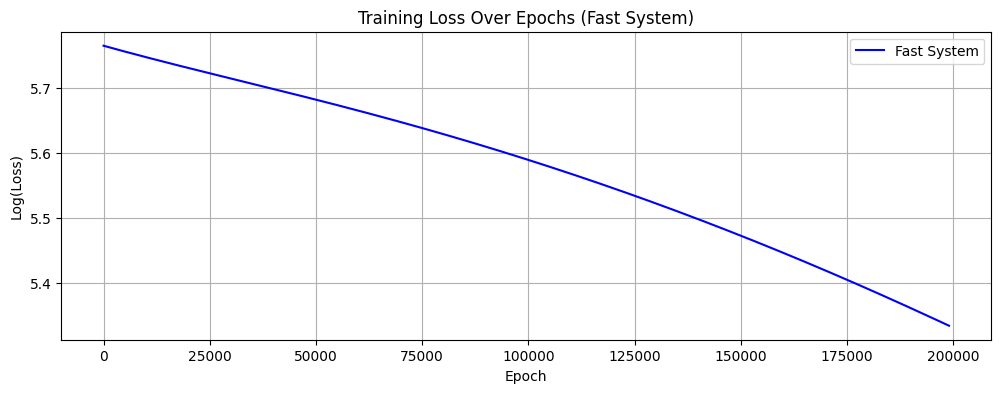

In [5]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_slow  = slow_system_PINN().to(torch.float64)  
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) +\
                                 list(model_slow.parameters()) +\
                                 list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 200000

    #xf2_end, yf2_end =  np.random.uniform(1, 2) , np.random.uniform(-1, 0) #-1, 2 #

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2,\
                                    t_tensor, tau_tensor, t2_tensor,\
                                    phi_init, c1_init, c2_init, w_init,\
                                    phi_slow_init, c1_slow_init, c2_slow_init, w_slow_init,\
                                    phi_end, c1_end, c2_end, w_end,\
                                    phi_slow_end, c1_slow_end, c2_slow_end, w_slow_end,\
                                    eps, weight_fast=1.0, weight_slow=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
            phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
            phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
            #J1, J2   = j1_pred_slow[0], j2_pred_slow[0]
            #u_a, u_b = u_pred_fast[-1], u_pred_fast2[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}') 
        loss_values.append(loss_total.item())
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_slow.eval()
    model_fast2.eval()
    with torch.no_grad():
        # Predictions for fast system
        phi_pred_fast, u_pred_fast, c1_pred_fast, c2_pred_fast, j1_pred_fast, j2_pred_fast, w_pred_fast = model_fast(t_tensor).numpy().T
        phi_pred_slow, u_pred_slow, c1_pred_slow, c2_pred_slow, j1_pred_slow, j2_pred_slow, w_pred_slow = model_slow(tau_tensor).numpy().T
        phi_pred_fast2, u_pred_fast2, c1_pred_fast2, c2_pred_fast2, j1_pred_fast2, j2_pred_fast2, w_pred_fast2 = model_fast2(t2_tensor).numpy().T
             
    

In [6]:
#print(J1)
#print(J2)
#print(j1_pred_fast.shape)
#print(j1_pred_fast[0])
#print(j1_pred_fast[-1])
#print('')

#print(j1_pred_slow[0])
#print(j1_pred_slow[-1])
#print('')

#print(j1_pred_fast2[0])
#print(j1_pred_fast2[-1])

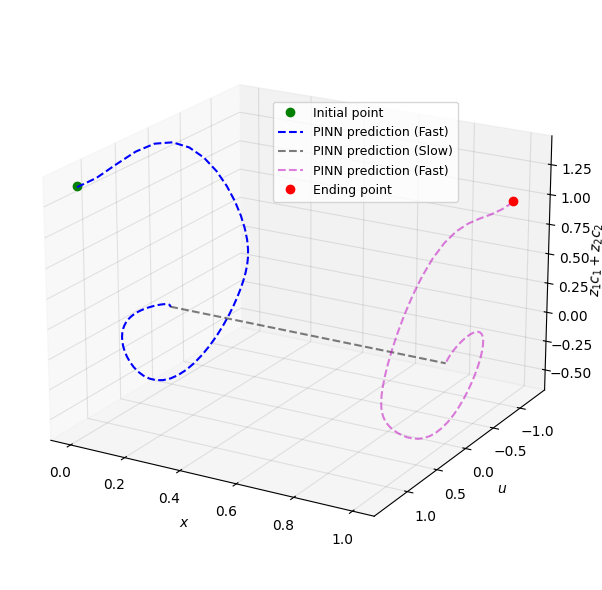

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(w_init, u_pred_fast[0], z1 * c1_init + z2 * c2_init, 'go', label='Initial point')

ax.plot(w_pred_fast, u_pred_fast, z1 * c1_pred_fast + z2 * c2_pred_fast, 'b--', label='PINN prediction (Fast)')


ax.plot(w_pred_slow + w_pred_fast[-1],\
        u_pred_slow + u_a,\
        z1 * c1_pred_slow + z2 * c2_pred_slow + z1 * c1_slow_init + z2 * c2_slow_init,\
        'k--', label='PINN prediction (Slow)', alpha=0.5)


ax.plot(w_pred_fast2 , u_pred_fast2 , z1 * c1_pred_fast2 + z2 * c2_pred_fast2 ,\
                                        'm--', label='PINN prediction (Fast)', alpha=0.5)
ax.plot(w_end, u_pred_fast2[0], z1 * c1_end + z2 * c2_end, 'ro', label='Ending point')

ax.set_xlabel('$x$')
ax.set_ylabel('$u$')
ax.set_zlabel('$z_1 c_1 + z_2 c_2$', labelpad=1)
#ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_xaxis()

# Adjust the position of the legend box
#ax.legend(prop={'size': 5})  # Set font size to 10 points
#ax.legend(bbox_to_anchor=(0.45, 0.85))
ax.legend(prop={'size': 9}, bbox_to_anchor=(0.45, 0.85))

# Adjust the transparency of the grid
ax.xaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))  # RGBA: last value is alpha
ax.yaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))
ax.zaxis._axinfo['grid'].update(color=(0.1, 0.1, 0.1, 0.1))

# Rotating the figure by 20 degrees
ax.view_init(elev=20, azim=120)

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

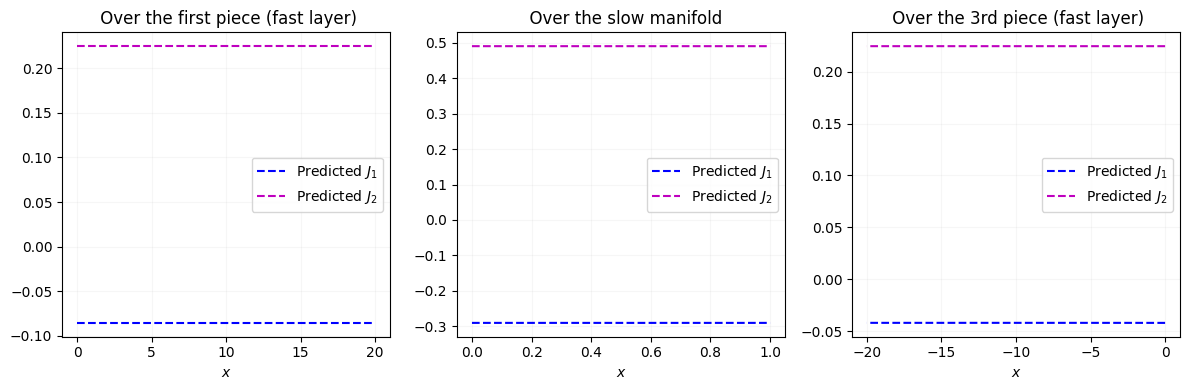

In [8]:


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b--', label='Predicted $J_1$')
plt.plot(t, j2_pred_fast, 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $J_1$')
plt.plot(tau, j2_pred_slow, 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title('  Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $J_1$')
plt.plot(t2, j2_pred_fast2 , 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()



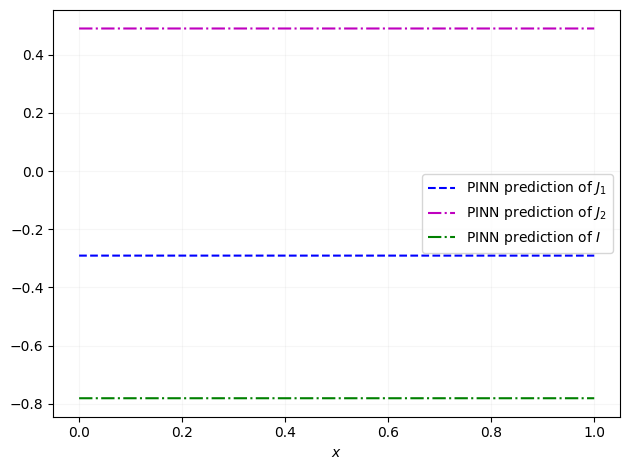

In [9]:
plt.figure(figsize=(6.4, 4.8))

# Plot the data
plt.plot(tau, j1_pred_slow, 'b--', label='PINN prediction of $J_1$')
plt.plot(tau, j2_pred_slow, 'm-.', label='PINN prediction of $J_2$')
plt.plot(tau, z1*j1_pred_slow + z2*j2_pred_slow, 'g-.', label='PINN prediction of $I$')

# Label the axes
plt.xlabel('$x$')
#plt.ylabel('Flux ($J$)')


# Add grid and legend
plt.grid(True, alpha=0.1)
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


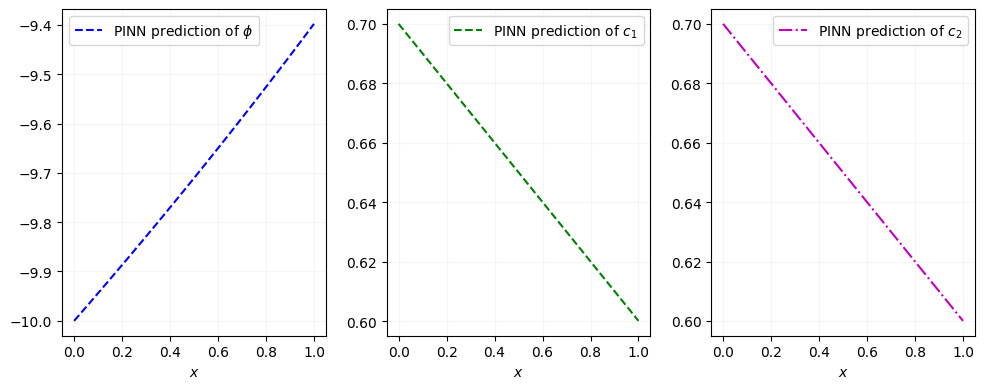

In [10]:
plt.figure(figsize=(10, 4))


plt.subplot(1, 3, 1)
plt.plot(tau, phi_pred_slow, 'b--', label='PINN prediction of $\phi$')
plt.xlabel('$x$')
#plt.ylabel('Concentration ($c$)')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'g--', label='PINN prediction of $c_1$')
plt.xlabel('$x$')
#plt.ylabel('Concentration ($c$)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(tau, c2_pred_slow, 'm-.', label='PINN prediction of $c_2$')
plt.xlabel('$x$')
#plt.ylabel('Concentration ($c$)')
#plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()


plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

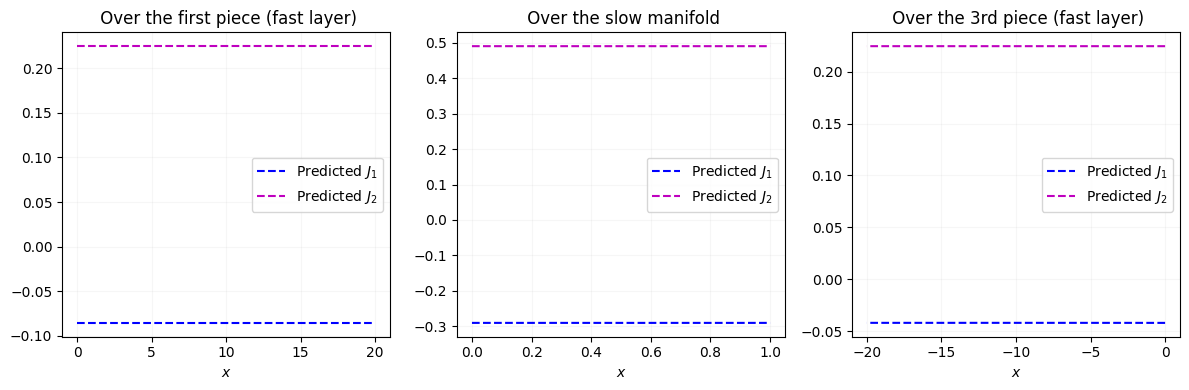

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b--', label='Predicted $J_1$')
plt.plot(t, j2_pred_fast, 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $J_1$')
plt.plot(tau, j2_pred_slow, 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $J_1$')
plt.plot(t2, j2_pred_fast2 , 'm--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

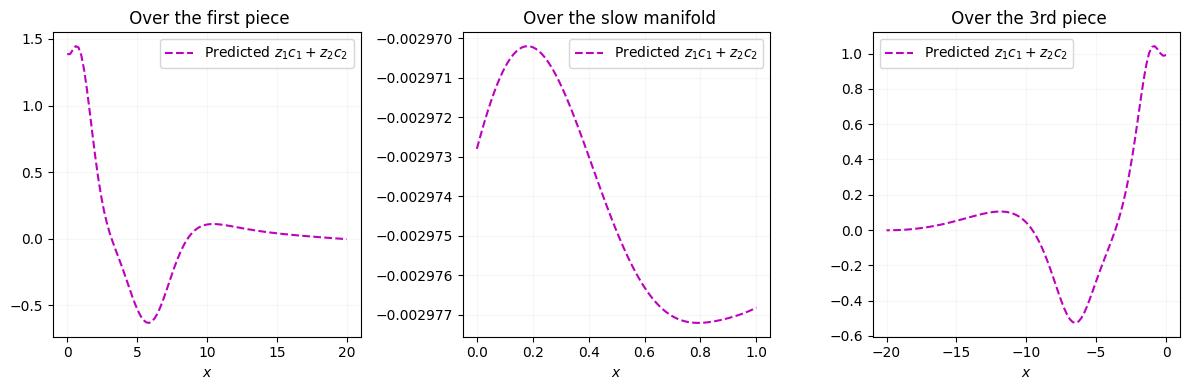

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, z1 * c1_pred_fast + z2 * c2_pred_fast, 'm--', label='Predicted $z_1 c_1+ z_2  c_2$')
plt.xlabel('$x$')
plt.title(' Over the first piece')
plt.grid(True, alpha=0.1)
plt.legend()

zc_slow_init = z1 * c1_pred_fast[-1] + z2 * c2_pred_fast[-1]
plt.subplot(1, 3, 2)
plt.plot(tau, z1 * c1_pred_slow + z2 * c2_pred_slow + zc_slow_init, 'm--', label='Predicted $z_1 c_1+ z_2  c_2$')
plt.xlabel('$x$')
#plt.ylabel('$z_1 c_1+ z_2  c_2$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, z1 * c1_pred_fast2 + z2 * c2_pred_fast2 , 'm--', label='Predicted $z_1 c_1+ z_2  c_2$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

### In the following, we would like to investigate whether the variables are fast or slow based on their dynamic on fast layers and slow layer:

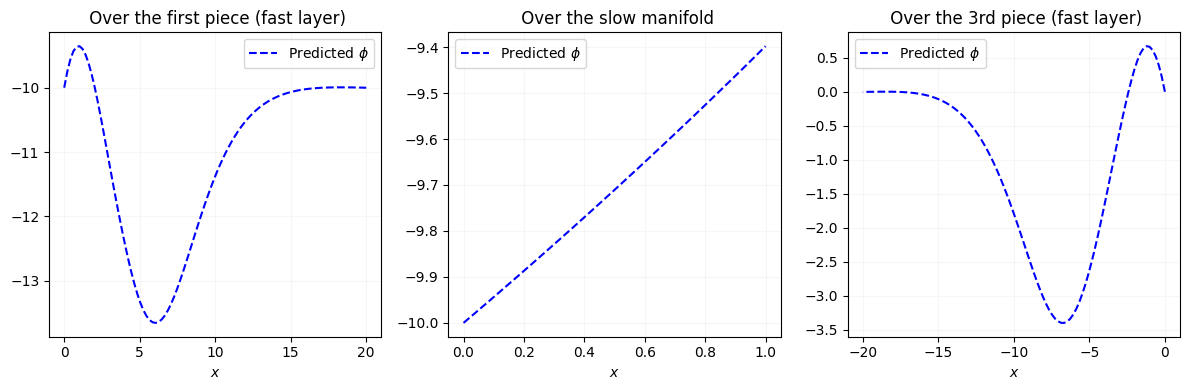

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, phi_pred_fast, 'b--', label='Predicted $\phi$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, phi_pred_slow, 'b--', label='Predicted $\phi$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, phi_pred_fast2 , 'b--', label='Predicted $\phi$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

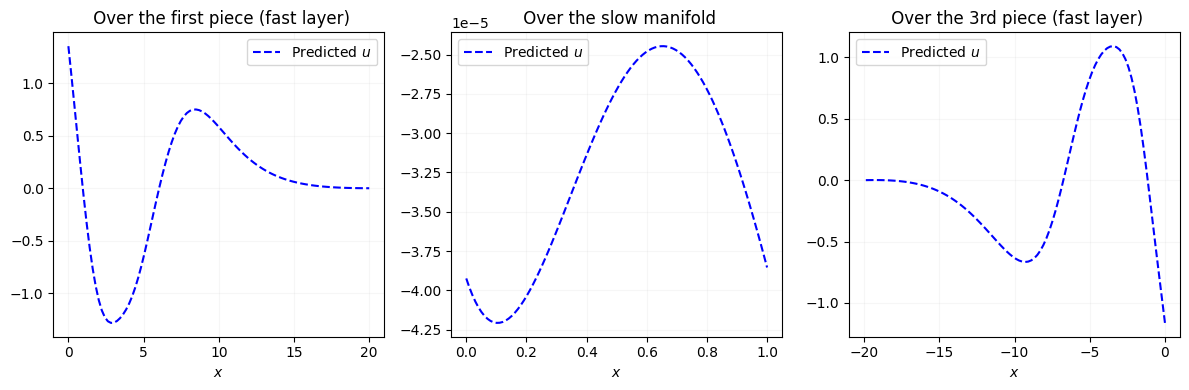

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, u_pred_fast, 'b--', label='Predicted $u$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, u_pred_slow, 'b--', label='Predicted $u$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, u_pred_fast2 , 'b--', label='Predicted $u$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

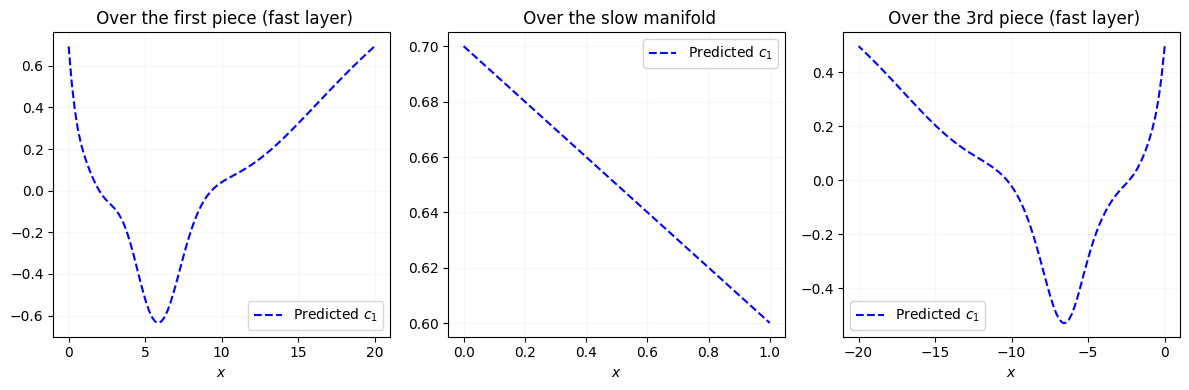

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c1_pred_fast, 'b--', label='Predicted $c_1$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, c1_pred_slow, 'b--', label='Predicted $c_1$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, c1_pred_fast2 , 'b--', label='Predicted $c_1$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

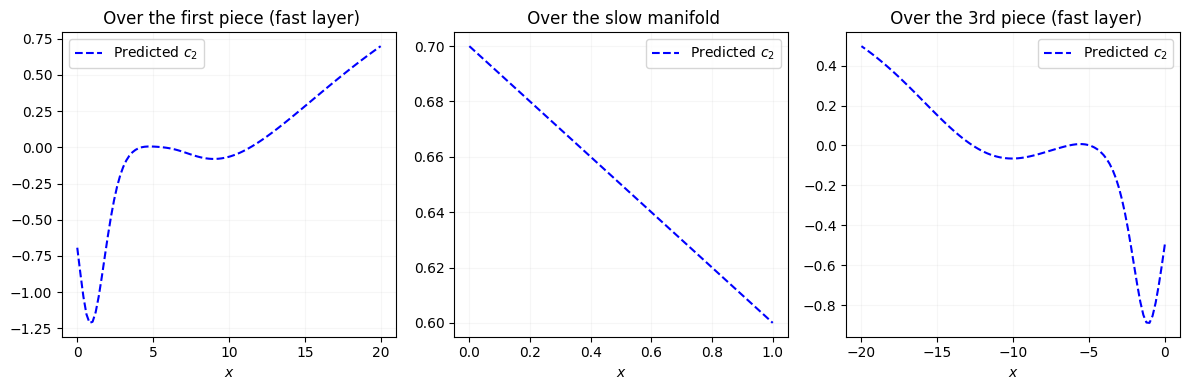

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, c2_pred_fast, 'b--', label='Predicted $c_2$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, c2_pred_slow, 'b--', label='Predicted $c_2$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, c2_pred_fast2 , 'b--', label='Predicted $c_2$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

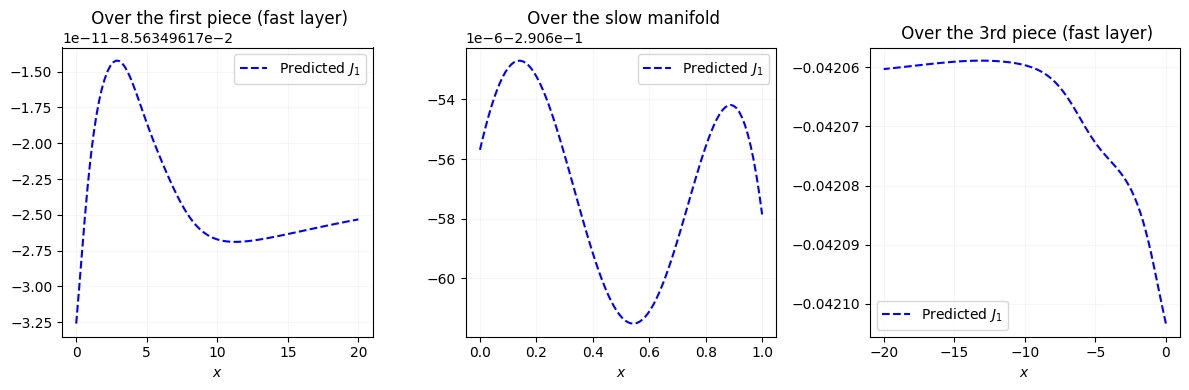

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j1_pred_fast, 'b--', label='Predicted $J_1$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, j1_pred_slow, 'b--', label='Predicted $J_1$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, j1_pred_fast2 , 'b--', label='Predicted $J_1$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

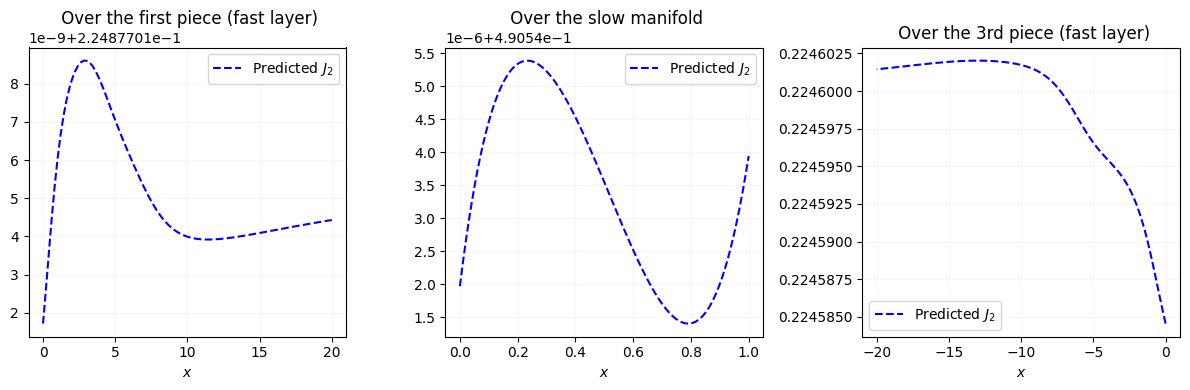

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(t, j2_pred_fast, 'b--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the first piece (fast layer)')
plt.grid(True, alpha=0.1)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(tau, j2_pred_slow, 'b--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the slow manifold')
plt.grid(True, alpha=0.1)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, j2_pred_fast2 , 'b--', label='Predicted $J_2$')
plt.xlabel('$x$')
plt.title(' Over the 3rd piece (fast layer)')
plt.legend()

plt.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()